# Evaluating Multi-Modal RAG

In [ ]:
# %pip install llama_index ftfy regex tqdm -q
# %pip install git+https://github.com/openai/CLIP.git -q
# %pip install torch torchvision -q
# %pip install matplotlib scikit-image -q
# %pip install -U qdrant_client -q

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

## Spelling In ASL

Load in our data

In [ ]:
from llama_index.multi_modal_llms.generic_utils import (
    load_image_urls,
)
from llama_index import SimpleDirectoryReader

image_path = "/Users/nerdai/Datasets/Images/asl-labelled"
image_documents = SimpleDirectoryReader(image_path).load_data()

Create the asl vector index

In [ ]:
from llama_index.schema import Document, ImageNode, TextNode

LETTERS = [
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "J",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "W",
    "X",
    "Y",
    "Z",
    "SPACE",
]

text_documents = [Document(text=letter) for letter in LETTERS]

In [ ]:
from llama_index.indices.multi_modal.base import MultiModalVectorStoreIndex
from llama_index.node_parser import SimpleNodeParser

node_parser = SimpleNodeParser.from_defaults()
image_nodes = node_parser.get_nodes_from_documents(image_documents)
text_nodes = node_parser.get_nodes_from_documents(text_documents)
asl_index = MultiModalVectorStoreIndex(
    image_nodes + text_nodes,
)

In [ ]:
# use as retriever
retriever_engine = asl_index.as_retriever(image_similarity_top_k=3)

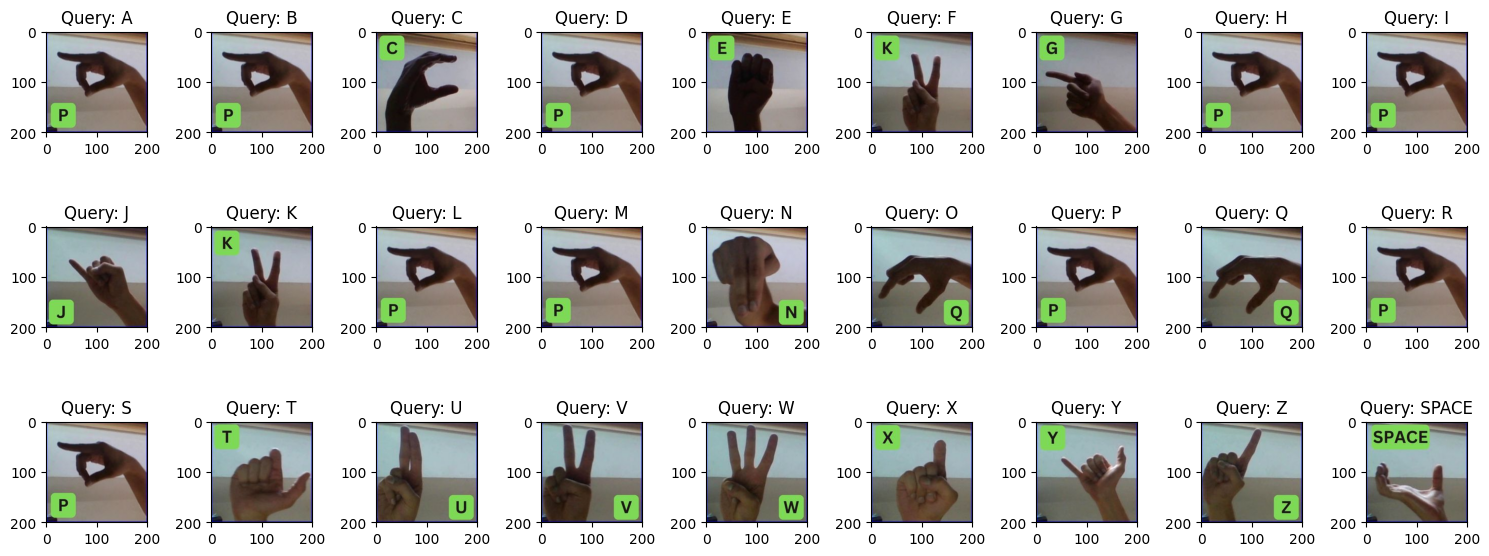

In [ ]:
f, axarr = plt.subplots(3, 9)
f.set_figheight(6)
f.set_figwidth(15)
ix = 0
for jx, letter in enumerate(LETTERS):
    retrieval_results = retriever_engine.retrieve(letter)
    image_node = None
    text_node = None
    for r in retrieval_results:
        if isinstance(r.node, TextNode):
            text_node = r
        if isinstance(r.node, ImageNode):
            image_node = r
            break

    img_path = image_node.metadata["file_path"]
    image = Image.open(img_path).convert("RGB")
    axarr[int(jx / 9), jx % 9].imshow(image)
    axarr[int(jx / 9), jx % 9].set_title(f"Query: {letter}")

plt.setp(axarr, xticks=[0, 100, 200], yticks=[0, 100, 200])
f.tight_layout()
plt.show()

## RAG

In [ ]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.multi_modal_llms.replicate_multi_modal import (
    ReplicateMultiModal,
)

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", max_new_tokens=300
)

multi_modal_llm = ReplicateMultiModal(
    model="yorickvp/llava-13b:2facb4a474a0462c15041b78b1ad70952ea46b5ec6ad29583c0b29dbd4249591",
    max_new_tokens=300,
)

In [ ]:
from llama_index.prompts import PromptTemplate

qa_tmpl_str = (
    "Images of hand gestures for ASL are provided.\n"
    "---------------------\n"
    "{context_str}\n"
    "---------------------\n"
    "Using only the images provided, first verify that the.\n"
    "provided image can be used to answer the query. If it is useful\n"
    "then, answer the query. Otherwise, don't provide an answer.\n"
    "Query: {query_str}\n"
    "Answer: "
)
qa_tmpl = PromptTemplate(qa_tmpl_str)

query_engine = asl_index.as_query_engine(
    multi_modal_llm=openai_mm_llm, text_qa_template=qa_tmpl
)

In [ ]:
query_str = "How can I sign a C? Use only the image provided."
response = query_engine.query(query_str)

In [ ]:
print(response)

To sign the letter "C" in American Sign Language (ASL), you can use the hand gesture from the provided image marked with 'C'. This gesture is made by holding your hand up and curving your fingers to form the shape of the letter "C".


### Retriever Evaluation

#### Hit Rate and MRR 

In [ ]:
from llama_index.evaluation import MultiModalRetrieverEvaluator

retriever_evaluator = MultiModalRetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=retriever_engine
)

In [ ]:
# create the qa dataset
import uuid
import re
from llama_index.evaluation import LabelledQADataset

reg_ex = r"(?:([A-Z]+).jpg)"
query_str = "How can I sign a {symbol}? Use only the image provided."

queries = {}
relevant_docs = {}
for img_node in image_nodes:
    match = re.search(reg_ex, img_node.metadata["file_path"])
    if match:
        query = query_str.format(symbol=match.group(1))
        id_ = str(uuid.uuid4())
        queries[id_] = query
        relevant_docs[id_] = [img_node.id_]

qa_dataset_image = LabelledQADataset(
    queries=queries, relevant_docs=relevant_docs, corpus={}, mode="image"
)

queries = {}
relevant_docs = {}
for node in text_nodes:
    query = query_str.format(symbol=node.text)
    id_ = str(uuid.uuid4())
    queries[id_] = query
    relevant_docs[id_] = [node.id_]

qa_dataset_text = LabelledQADataset(
    queries=queries,
    relevant_docs=relevant_docs,
    corpus={},
)

In [ ]:
eval_results_image = await retriever_evaluator.aevaluate_dataset(
    qa_dataset_image
)
eval_results_text = await retriever_evaluator.aevaluate_dataset(
    qa_dataset_text
)

In [ ]:
import pandas as pd


def display_results(name, eval_results):
    """Display results from evaluate."""

    metric_dicts = []
    for eval_result in eval_results:
        metric_dict = eval_result.metric_vals_dict
        metric_dicts.append(metric_dict)

    full_df = pd.DataFrame(metric_dicts)

    hit_rate = full_df["hit_rate"].mean()
    mrr = full_df["mrr"].mean()
    modality = eval_result.mode.value

    metric_df = pd.DataFrame(
        {
            "Encoder Name": [name],
            "Hit Rate": [hit_rate],
            "MRR": [mrr],
            "Modality": [modality],
        }
    )

    return metric_df

In [ ]:
results_df = pd.concat(
    [
        display_results(
            asl_index.image_embed_model.model_name, eval_results_image
        ),
        display_results(
            asl_index.service_context.embed_model.model_name, eval_results_text
        ),
    ]
)
results_df

,Encoder Name,Hit Rate,MRR,Modality
0,ViT-B/32,0.740741,0.703704,image
0,text-embedding-ada-002,1.000000,0.981481,text


### Generation Evaluation

In [ ]:
print(str(response))

To sign the letter "C" in American Sign Language (ASL), you can use the hand gesture from the provided image marked with 'C'. This gesture is made by holding your hand up and curving your fingers to form the shape of the letter "C".


#### Human Judgement

#### LMM-As-A-Judge (Correctness & Faithfulness)